# Load H5/NC files directly into tensorflow

The dataset is to large to load into memory directly. Therefor we will define a generator first that can be used to get a part of the dataset

In [12]:
import h5py
import tensorflow as tf
import numpy as np
import datetime
import netCDF4 

import matplotlib.pyplot as plt

In [120]:
def plot_radar(rdr_arr):
    mask= (rdr_arr == 65535)
    mx = np.ma.masked_array(rdr_arr, mask)
    plt.imshow(np.squeeze(mx))
    plt.axis('off')
    plt.show()

In [100]:
ts = 201812190800
path = '/nobackup/users/schreurs/project_GAN/dataset_radar' + '/RAD_NL25_RAC_RT_{}.h5'.format(ts)

with h5py.File(path, 'r') as f:
    radar_img = f['image1']['image_data'][:]
    

(765, 700, 1)

In [112]:
# Based upon the following code:
# https://stackoverflow.com/questions/48309631/tensorflow-tf-data-dataset-reading-large-hdf5-files

class generator:
    def __init__(self, dt):
        self.dt = dt
        self.x_path = '/nobackup/users/schreurs/project_GAN/dataset_radar'
        self.y_path = '/nobackup/users/schreurs/project_GAN/dataset_aart'

    def __call__(self):
        x = self.get_x()
        y = self.get_y()
        yield x,y
        
    def get_x(self):

        ts = '{:%Y%m%d%H%M}'.format(a)
        
        path = '/nobackup/users/schreurs/project_GAN/dataset_radar' + '/RAD_NL25_RAC_RT_{}.h5'.format(ts)

        with h5py.File(path, 'r') as f:
            rain = f['image1']['image_data'][:]
            
            # Expand dimensions from (w,h) to (w,h,c)
            rain = np.expand_dims(rain, axis=-1)
            return rain
        
        
    def get_y(self):
        year = self.dt.strftime('%Y')
        month = self.dt.strftime('%m')
        ts = '{:%Y%m%d%H%M}'.format(a)
        path = self.y_path + '/{}/{}/{}/RAD_NL25_RAC_MFBS_EM_5min_{}.nc'.format(year,year,month,ts)

        with netCDF4.Dataset(path, 'r') as f:
            rain = f['image1_image_data'][:]
            
            # Change to image format (w,h,c) instead of (c,w,h)
            rain = np.moveaxis(rain, 0, -1)
            return rain

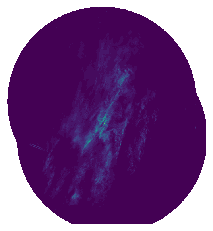

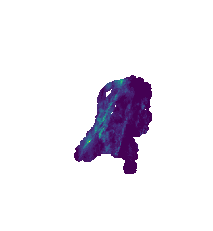

In [129]:
a = datetime.datetime(year=2020, month=1,day=15,hour=14, minute=0)


x_type = tf.uint16
y_type= tf.float32 
x_shape = y_shape = tf.TensorShape([765, 700, 1])

ds = tf.data.Dataset.from_generator(
    generator(a), 
    output_types= (x_type, y_type),
    output_shapes= (x_shape, y_shape),
    )


for element in ds:
    x, y = element
    plot_radar(x)
    plot_radar(y)

In [130]:
np.unique(y)

array([0.0000000e+00, 9.9999998e-03, 2.0000000e-02, 2.9999999e-02,
       3.9999999e-02, 4.9999997e-02, 5.9999999e-02, 7.0000000e-02,
       7.9999998e-02, 8.9999996e-02, 9.9999994e-02, 1.1000000e-01,
       1.2000000e-01, 1.3000000e-01, 1.4000000e-01, 1.4999999e-01,
       1.6000000e-01, 1.7000000e-01, 1.7999999e-01, 1.9000000e-01,
       1.9999999e-01, 2.0999999e-01, 2.2000000e-01, 2.2999999e-01,
       2.3999999e-01, 2.5000000e-01, 2.5999999e-01, 2.6999998e-01,
       2.8000000e-01, 2.8999999e-01, 2.9999998e-01, 3.1000000e-01,
       3.1999999e-01, 3.2999998e-01, 3.4000000e-01, 3.4999999e-01,
       3.5999998e-01, 3.7000000e-01, 3.8000000e-01, 3.8999999e-01,
       3.9999998e-01, 4.1000000e-01, 4.1999999e-01, 4.4000000e-01,
       4.4999999e-01, 4.5999998e-01, 6.5535000e+04], dtype=float32)